In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, LSTM, Masking, Input, GRU, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras import regularizers
from sklearn.utils import shuffle

2022-09-11 22:10:01.191689: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-11 22:10:01.283013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-11 22:10:01.283182: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
file_path = "./Jan06_FlavFix_smear_1_std_xtd_zst.h5"
f5 = h5py.File(file_path, 'r')

In [3]:
x_train = np.array( f5['x_train'] )
y_train = to_categorical ( np.array( f5['y_train'] ) )
w_train = np.array( f5['w_train'] )

(array([[400610.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0., 300906.],
        [601755.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  99761.],
        [400667.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0., 300849.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 3 BarContainer objects>)

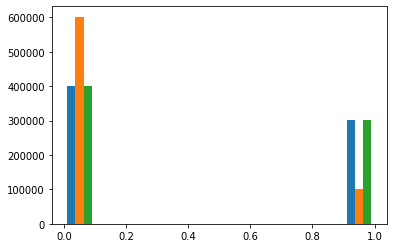

In [4]:
plt.hist(y_train[:])

### Shuffle training data

In [5]:
x_train, y_train, w_train = shuffle(x_train, y_train, w_train)

In [6]:
print("x-shape: ", x_train.shape)
print("y-shape: ", y_train.shape)
print("w-shape: ", w_train.shape)

x-shape:  (701516, 15, 6)
y-shape:  (701516, 3)
w-shape:  (701516,)


### GRU

In [ ]:
def grumodel(max_len, n_var, rec_units, ndense=[10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform', domask=False):
    
    rec_layer = 'GRU'
    
    track_inputs = Input(shape=(max_len, n_var,))
    
    if domask:
        hidden = Masking( mask_value=0, name="masking_1")(track_inputs)
    else:
        hidden = track_inputs
    

    if l1_reg > 1e-6 and l2_reg > 1e-6:
        hidden = GRU(units=rec_units,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg),
                  name = 'gru_l1l2')(hidden)
    elif l1_reg > 1e-6:
        hidden = GRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1(l1 = l1_reg),
                  name = 'gru_l1')(hidden)
    elif l2_reg > 1e-6:
        hidden = GRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l2(l2 = l2_reg),
                  name = 'gru_l2')(hidden)
    else:
        hidden = GRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  name = 'gru')(hidden)
            

    for ind,nd in enumerate(ndense):
        hidden = Dense(nd, activation='relu', kernel_initializer=dense_kernel_init, name=f'dense_{ind}' )(hidden)
    
    output = Dense(3, activation='softmax', kernel_initializer=dense_kernel_init, name = 'output_softmax')(hidden)
    
    model = Model(inputs=track_inputs, outputs=output)
    
    d_layers = ''.join([ str(dl) for dl in ndense ])
        
    if domask:
        mname  = f'MASKED_rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    else:
        mname  = f'rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    mname += f'LSTMKernelInit.{rec_kernel_init}_DenseKernelInit.{dense_kernel_init}'
    mname += f'KRl1.{l1_reg}_KRl2.{l2_reg}_recAct.{rec_act}' #LSTM kernel regularizer
    
    if 'none' not in extra_lab:
        mname += f'_{extra_lab}'
    
    return model, mname

#     mask = Masking( mask_value=0, name="masking_1")(track_inputs)
##########################################
#                   use_bias=False,
#                   activation='relu',
#                   recurrent_activation='relu',
#                   kernel_regularizer = regularizers.l1_l2(l1= 0.001, l2 = 0.0001), 
#                   bias_regularizer = regularizers.l1_l2(l1= 1, l2 = 1), 
#                   activity_regularizer=regularizers.l1_l2(l1= 0.001, l2 = 0.0001),
##########################################

### LSTM

In [ ]:
def lstmmodel(max_len, n_var, rec_units, ndense=[10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform', domask=False):
    
    rec_layer = 'LSTM'
    
    track_inputs = Input(shape=(max_len, n_var,))
    
    if domask:
        hidden = Masking( mask_value=0, name="masking_1")(track_inputs)
    else:
        hidden = track_inputs
    
    if l1_reg > 1e-6 and l2_reg > 1e-6:
        hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg),
                  name = 'lstm1_l1l2')(hidden)
    elif l1_reg > 1e-6:
        hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1(l1 = l1_reg),
                  name = 'lstm1_l1')(hidden)
    elif l2_reg > 1e-6:
        hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l2(l2 = l2_reg),
                  name = 'lstm1_l2')(hidden)
    else:
        hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  name = 'lstm1')(hidden)

    for ind,nd in enumerate(ndense):
        hidden = Dense(nd, activation='relu', kernel_initializer=dense_kernel_init, name=f'dense_{ind}' )(hidden)
    
    output = Dense(3, activation='softmax', kernel_initializer=dense_kernel_init, name = 'output_softmax')(hidden)
    
    model = Model(inputs=track_inputs, outputs=output)
    
    d_layers = ''.join([ str(dl) for dl in ndense ])
        
    if domask:
        mname  = f'MASKED_rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    else:
        mname  = f'rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    mname += f'LSTMKernelInit.{rec_kernel_init}_DenseKernelInit.{dense_kernel_init}'
    mname += f'KRl1.{l1_reg}_KRl2.{l2_reg}_recAct.{rec_act}' #LSTM kernel regularizer
    
    if 'none' not in extra_lab:
        mname += f'_{extra_lab}'
    
    return model, mname

#     mask = Masking( mask_value=0, name="masking_1")(track_inputs)
##########################################
#                   use_bias=False,
#                   activation='relu',
#                   recurrent_activation='relu',
#                   kernel_regularizer = regularizers.l1_l2(l1= 0.001, l2 = 0.0001), 
#                   bias_regularizer = regularizers.l1_l2(l1= 1, l2 = 1), 
#                   activity_regularizer=regularizers.l1_l2(l1= 0.001, l2 = 0.0001),
##########################################

### Train Model

In [ ]:
l1_reg = 0
l2_reg = 0

## GRU Model
model, model_name = grumodel(15, 6, 120, [50, 10],l1_reg=l1_reg, l2_reg=l2_reg)

## LSTM Model
#model, model_name = lstmmodel(15, 6, 120, [50, 10],l1_reg=l1_reg, l2_reg=l2_reg)

model.summary()

In [ ]:
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'], weighted_metrics=[])
model_output = f'small_gru/model_gru_weights.h5'
train = True
if train:
    history = model.fit(new_x_train , new_y_train,
                batch_size=2**14,
                epochs=150,
                validation_split=0.1,
                shuffle = True,
                sample_weight= w_train,
                callbacks = [
                    EarlyStopping(verbose=True, patience=10, monitor='val_accuracy'),
                    ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                    ],
                verbose=True
                )
        
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Check Performance

In [ ]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

In [ ]:
print("x-shape: ", x_test.shape)
print("y-shape: ", y_test.shape)

plt.hist(y_test[:])

In [ ]:
y_keras = model.predict(x_test, batch_size=2**10)
auc_score = roc_auc_score(y_test, y_keras)
print("AUC score:", auc_score)